In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

# 2. Paths
train_dir = '/kaggle/input/comfsys-challenge/Comys_Hackathon5/Task_A/train'
val_dir = '/kaggle/input/comfsys-challenge/Comys_Hackathon5/Task_A/val'

# 3. Load Data
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=1, class_mode='binary', shuffle=False)
val_gen = datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=1, class_mode='binary', shuffle=False)

# 4. Feature Extraction with EfficientNetB3
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
model = Model(inputs=base_model.input, outputs=x)

train_features = model.predict(train_gen, steps=len(train_gen), verbose=1)
val_features = model.predict(val_gen, steps=len(val_gen), verbose=1)
train_labels = train_gen.classes
val_labels = val_gen.classes

# 5. Handle Class Imbalance: Upsample class 0
train_combined = np.hstack((train_features, train_labels.reshape(-1, 1)))
class_0 = train_combined[train_combined[:, -1] == 0]
class_1 = train_combined[train_combined[:, -1] == 1]
class_0_upsampled = resample(class_0, replace=True, n_samples=len(class_1), random_state=42)
balanced = np.vstack((class_1, class_0_upsampled))
np.random.shuffle(balanced)

X_train = balanced[:, :-1]
y_train = balanced[:, -1]

# 6. Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(val_features)



Threshold: 0.5
              precision    recall  f1-score   support

           0      0.908     0.747     0.819        79
           1      0.944     0.983     0.963       343

    accuracy                          0.938       422
   macro avg      0.926     0.865     0.891       422
weighted avg      0.937     0.938     0.936       422

Confusion Matrix:
 [[ 59  20]
 [  6 337]]
Accuracy: 0.9383886255924171

Threshold: 0.45
              precision    recall  f1-score   support

           0      0.898     0.671     0.768        79
           1      0.928     0.983     0.955       343

    accuracy                          0.924       422
   macro avg      0.913     0.827     0.861       422
weighted avg      0.923     0.924     0.920       422

Confusion Matrix:
 [[ 53  26]
 [  6 337]]
Accuracy: 0.9241706161137441

Threshold: 0.4
              precision    recall  f1-score   support

           0      0.893     0.633     0.741        79
           1      0.921     0.983     0.951   

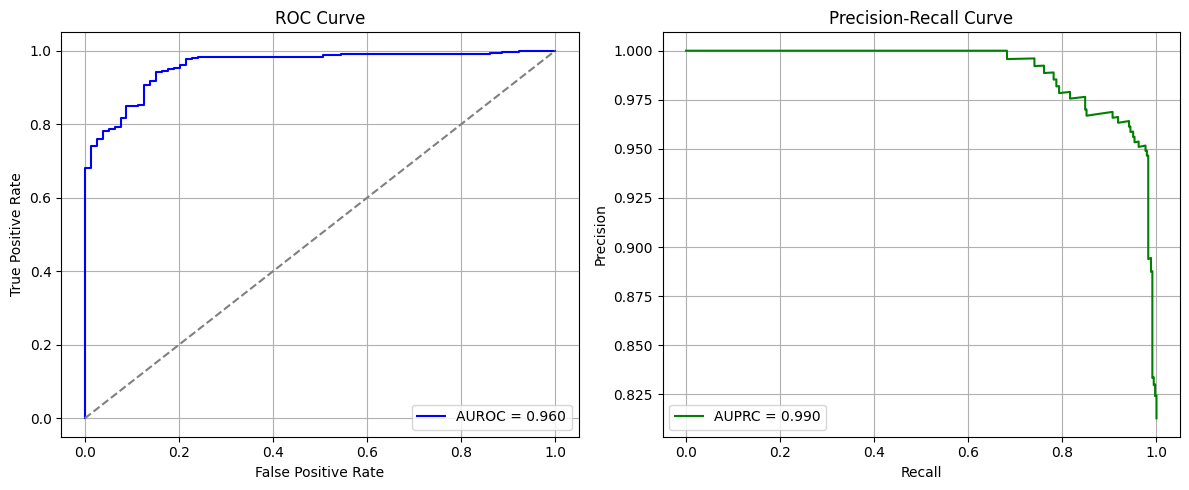

In [ ]:
# Imports
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Data loading steps assumed to be completed already
# Assume:
# X_train_scaled, y_train, X_val_scaled, val_labels, y_probs (if not using VotingClassifier yet)

# Models
rf = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
xgb = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=42)
cat = CatBoostClassifier(iterations=100, learning_rate=0.05, depth=5, verbose=0, random_state=42)

# Voting Classifier (Soft Voting)
voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('cat', cat)],
    voting='soft'
)

# Fit the model
voting_clf.fit(X_train_scaled, y_train)

# Predict probabilities
y_probs = voting_clf.predict_proba(X_val_scaled)[:, 1]

# Evaluate for different thresholds
for thresh in [0.5, 0.45, 0.4, 0.35]:
    y_pred = (y_probs >= thresh).astype(int)
    print(f"\nThreshold: {thresh}")
    print(classification_report(val_labels, y_pred, digits=3))
    print("Confusion Matrix:\n", confusion_matrix(val_labels, y_pred))
    print("Accuracy:", accuracy_score(val_labels, y_pred))

# AUROC and AUPRC
fpr, tpr, _ = roc_curve(val_labels, y_probs)
roc_auc = roc_auc_score(val_labels, y_probs)
precision, recall, _ = precision_recall_curve(val_labels, y_probs)
pr_auc = auc(recall, precision)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'AUROC = {roc_auc:.3f}', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'AUPRC = {pr_auc:.3f}', color='green')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
